**Analisis de la Encuesta Continua de Hogares 2024**

- Dataset: https://www4.ine.gub.uy/Anda5/index.php/catalog/767/get-microdata
- Diccionario: https://www4.ine.gub.uy/Anda5/index.php/catalog/767/data-dictionary/F4?file_name=ECH_implantacion_2024

In [20]:
# CARGO EL CSV CON PANDAS
import pandas as pd
ech = pd.read_csv(r'C:\Users\ut603933\UM\tesis\ECH_implantacion_2024.csv')

In [2]:
# INFORMACION DEL DATASET
# print("Información del dataset de entrenamiento:")
# print(ech.info())
#print("\nResumen estadístico:")
#print(ech.describe())

In [3]:
# VERIFICAR VALORES NULOS
# print("Columnas con valores nulos (por nombre de la variable):")
# print(ech.isnull().sum()[ech.isnull().sum() > 0].sort_index())
#print("Columnas con valores nulos (ordenadas):")
#print(ech.isnull().sum()[ech.isnull().sum() > 0].sort_values(ascending=False))

In [4]:
# from tabulate import tabulate
# print(tabulate(ech, headers = 'keys', tablefmt = 'psql'))

In [5]:
# MOSTRAR EL DF
# pd.set_option('display.max_rows', None)  # Show all rows
# pd.set_option('display.max_columns', 10)  # Show all columns
# pd.set_option('display.width', 100)  # Adjust display width
# pd.set_option('display.max_colwidth', None)  # Show full column contents
# print(ech)
# #pd.reset_option('all') # Restore default option

In [6]:
# ech.sample(5)

In [21]:
# IMPORTO LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# === 1. Información general del dataset ===
print("Dimensiones del dataset:", ech.shape)
print("\nPrimeras filas:")
display(ech.head())

print("\nTipos de datos:")
display(ech.dtypes.value_counts())

Dimensiones del dataset: (55923, 535)

Primeras filas:


,ID,nper,anio,mes,GR,region,REGION_4,dpto,nom_dpto,ccz,...,monto_imput_GAS,monto_imput_OSE,H_FONASA,montoGAS_RRAA,montoUTE_RRAA,montoOSE_RRAA,YDA,W_TRI,W_SEM,W_ANO
0,57612,1,2024,1,31,1,1,1,Montevideo,1,...,0.0,0.0,4206.36,0.0,0.0,0.0,68000.0,153,72,32
1,57613,1,2024,1,31,1,1,1,Montevideo,1,...,0.0,0.0,4206.36,0.0,0.0,0.0,50000.0,124,59,30
2,57614,1,2024,1,31,1,1,1,Montevideo,1,...,0.0,0.0,4206.36,0.0,0.0,0.0,74000.0,153,72,32
3,57615,1,2024,1,31,1,1,1,Montevideo,1,...,0.0,0.0,8412.72,0.0,0.0,0.0,220000.0,144,76,34
4,57615,2,2024,1,31,1,1,1,Montevideo,1,...,0.0,0.0,8412.72,0.0,0.0,0.0,220000.0,144,76,34



Tipos de datos:


int64      484
float64     49
object       2
Name: count, dtype: int64

In [23]:
# === 2. Análisis de valores nulos ===
nulos = ech.isnull().sum()
nulos = nulos[nulos > 0].sort_values(ascending=False)
print("\nColumnas con nulos (cantidad):")
display(nulos)


Columnas con nulos (cantidad):


f295      28066
f293      28066
d229      28066
d230      28066
d231      28066
d232      28066
d184      28066
d184_1    28066
f294      28066
d181      28066
f288      28066
f289      28066
f290      28066
f291_a    28066
f291_b    28066
f292      28066
c5_13     27857
d181_b    27857
d184_b    27857
dtype: int64

Verificando el diccionario, los valores nulos son para las variables:
- c5_13: PROBLEMAS DE LA VIVIENDA Pisos y muros agrietados
- d181, d181_b, d184, d184_1, d184_b, d229, d230, d231, d232: SERVICIO DOMESTICO
- f288, f289, f290, f291_a, f291_b, f292, f293, f294, f295: Lugar y modalidad de trabajo

In [24]:
nulos_pct = ech.isnull().mean().sort_values(ascending=False)
display(nulos_pct[nulos_pct > 0])

f288      0.501869
f295      0.501869
d231      0.501869
d230      0.501869
d229      0.501869
d181      0.501869
d184_1    0.501869
d184      0.501869
f289      0.501869
f290      0.501869
f291_a    0.501869
f291_b    0.501869
f292      0.501869
f293      0.501869
f294      0.501869
d232      0.501869
d181_b    0.498131
d184_b    0.498131
c5_13     0.498131
dtype: float64

Las preguntas son de los modulos:
-   Servicio doméstico → sólo hogares que contratan personal.
-   Lugar y modalidad de trabajo → sólo personas ocupadas.

Confirmamos que son variables condicionales por diseño: 
-   La mitad de la población no responde esas preguntas porque no aplica.
-   El 50% restante sí tiene datos válidos y útiles.

No eliminamos esas columnas por tener “demasiados nulos”, ya que no se trata de datos ausentes por error, sino de lógica del cuestionario.

Podemos usarlas de forma segmentada, por ejemplo:
-   Hacer modelos distintos para personas ocupadas (que tienen datos en f288–f295) y no ocupadas, o
-   Incluir una variable indicadora de “aplica o no aplica” para evitar que el modelo se confunda.

Son una señal indirecta de pertenencia a ciertos grupos: tener datos en esas columnas podría implicar estar ocupado o tener personal a cargo → lo que sí puede estar correlacionado con el ingreso.


Estadísticas de ingreso (YDA):


count    5.592300e+04
mean     1.063283e+05
std      9.331071e+04
min      0.000000e+00
25%      5.400000e+04
50%      8.187355e+04
75%      1.270000e+05
max      2.560000e+06
Name: YDA, dtype: float64

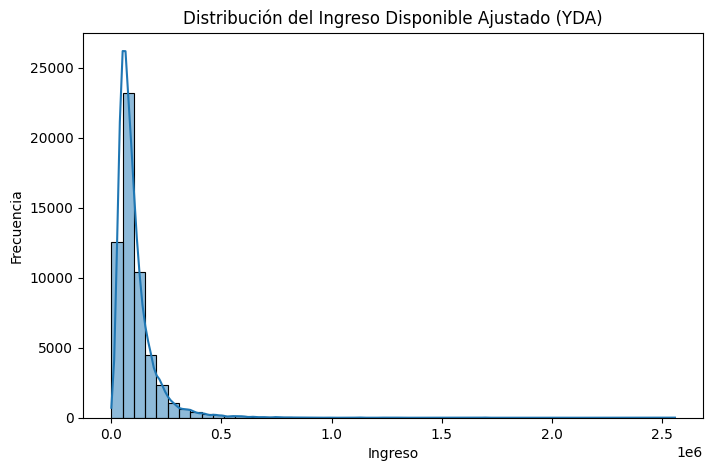

In [26]:
# === 3. Distribución de la variable objetivo ===
# Suponemos que la variable objetivo es 'YDA'
target = 'YDA'
print("\nEstadísticas de ingreso (YDA):")
display(ech[target].describe())

plt.figure(figsize=(8,5))
sns.histplot(ech[target], bins=50, kde=True)
plt.title('Distribución del Ingreso Disponible Ajustado (YDA)')
plt.xlabel('Ingreso')
plt.ylabel('Frecuencia')
plt.show()

Se observa que:
- Muy asimétrica (sesgo a la derecha).
- Muchos ingresos entre $0 y $200.000.
- Algunos valores extremos que superan el millón (outliers evidentes).

Tratamos a continuacion: 
- Usmos la variable log_YDA como target en modelos lineales y árboles si queremos reducir la sensibilidad a los valores extremos.
- Visualizamos un boxplot ya que el max es 25 veces el 75º percentil.
- Vemos valores en 0 ya que min = 0 → ¿Ingreso nulo o inactivo?

In [ ]:
# target en modelos lineales y árboles si queremos reducir la sensibilidad a los valores extremos
ech['log_YDA'] = np.log1p(ech['YDA'])  # log(1 + YDA)

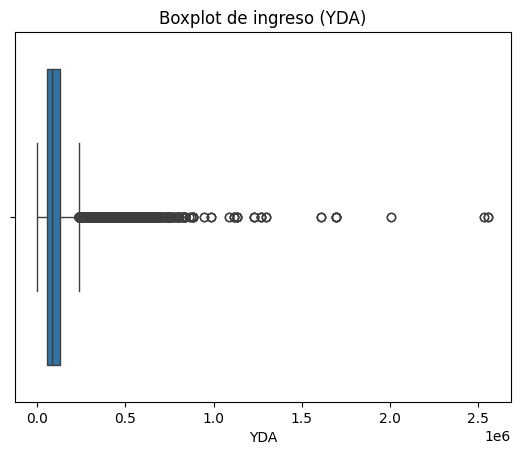

In [28]:
# visualizar con boxplot y/o stripplot
sns.boxplot(x=ech['YDA'])
plt.title("Boxplot de ingreso (YDA)")
plt.show()

La gráfica muestra claramente lo que ya anticipamos:
- Una alta concentración de valores en el rango bajo (entre $0 y $200.000).
- Una larga cola derecha de outliers extremos, que se extienden hasta los 2.5 millones.

🔍 Esto confirma que:
- El ingreso en la ECH 2024 está fuertemente sesgado.
- La dispersión es muy alta.
- Los outliers son numerosos pero no necesariamente errores.

In [ ]:
# ver valores en cero
ech[ech['YDA'] == 0].shape

(12, 536)

Esto significa que solo 12 personas tienen ingreso 0 declarado, lo cual:
- ✅ No es un problema de datos generalizado, ni requiere imputación.
- ⚠️ Pero sí vale la pena entender el perfil de estas 12 personas.

In [32]:
display(ech[ech['YDA'] == 0][['e27', 'e26', 'f269', 'd8_1', 'd9', 'c1']])  # o las columnas que representen edad, ocupación, tipo de hogar

,e27,e26,f269,d8_1,d9,c1
1186,30,1,2,5,1,3
3174,64,1,2,5,3,1
3175,61,2,2,5,3,1
5722,52,1,1,5,2,1
12984,61,1,2,5,2,2
24402,49,1,2,5,2,3
39054,51,2,1,1,3,1
39055,64,1,2,1,3,1
48247,26,1,1,6,2,1
55002,47,2,2,5,1,4


La mayoria inquilinos o arrendatarios (d8_1).

La distribución de YDA:
- Se comporta como es esperable en datos de ingreso.
- No requiere imputación de nulos en YDA (no hay).

✅ Conclusiones clave:
- Los valores extremos están presentes, pero no dominan.
- No es necesario eliminarlos todavía. Algunos modelos (como árboles) los manejan bien.

Transformación logarítmica es aconsejable.
Especialmente para modelos sensibles a la escala o distribución (Regresión Lineal, Redes Neuronales).

Pocos casos con ingreso cero.
Son casos especiales que podés dejar o filtrar si hacés segmentación (ej. "ocupados", "con ingreso distinto de cero", etc.).

Sí se beneficia de:
- Log-transformación (log1p).
- Revisión de outliers extremos.
- Segmentación posterior por tipo de población (ocupada/no ocupada).

In [11]:
# === 4. Identificar variables numéricas y categóricas ===
num_vars = ech.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_vars = ech.select_dtypes(include=['object', 'category']).columns.tolist()

# Eliminar la variable target de ambas listas si está incluida
if target in num_vars: num_vars.remove(target)
if target in cat_vars: cat_vars.remove(target)

print(f"Variables numéricas: {len(num_vars)}")
print(f"Variables categóricas: {len(cat_vars)}")

Variables numéricas: 532
Variables categóricas: 2


Muchas variables categóricas están codificadas numéricamente, por ejemplo:
- sexo: 1 = Hombre, 2 = Mujer
- estado civil actual: 1 = Separado, 2 = Divorciado, 3 = Casado, etc.
- nivel que esta cursando: 4 = Educacion media basica, 6 = Educacion media superior, etc.

Estas se almacenan como int64 o float64, por lo que pandas las interpreta como numéricas, cuando en realidad son categóricas ordinales o nominales.

No imputamos variables numericas ni categoricas.

In [ ]:
# === 5. Tratamiento de valores nulos ===
# Para numéricas: imputar con la mediana
#for col in num_vars:
#    if ech[col].isnull().any():
#        ech[col] = ech[col].fillna(ech[col].median())

# Para categóricas: imputar con una categoría especial
#for col in cat_vars:
#    if ech[col].isnull().any():
#        ech[col] = ech[col].fillna('No informado')

1. Reclasificar variables categóricas codificadas como numéricas: Muchas de estas variables deberían tratarse como categóricas.

In [13]:
# === 6. Codificación de variables categóricas ===
# Convertir binarias codificadas como 1/2 o Sí/No a 0/1
def codificar_binarias(df):
    for col in df.columns:
        if df[col].nunique() == 2:
            vals = sorted(df[col].dropna().unique())
            if set(vals) <= set([0,1,2]):
                df[col] = df[col].map({vals[0]: 0, vals[1]: 1})
    return df

ech = codificar_binarias(ech)

# One-hot encoding para variables categóricas no binarias
ech_encoded = pd.get_dummies(ech, columns=cat_vars, drop_first=True)


Top 10 variables correlacionadas con el ingreso (YDA):


HT11        0.998246
YDA_SVL     0.991424
YSVL        0.988927
d8_3        0.663271
eg_ps2      0.599231
HT13        0.584917
d14         0.573026
d21_15_4    0.558708
PT1         0.515934
d21_14_1    0.487742
Name: YDA, dtype: float64

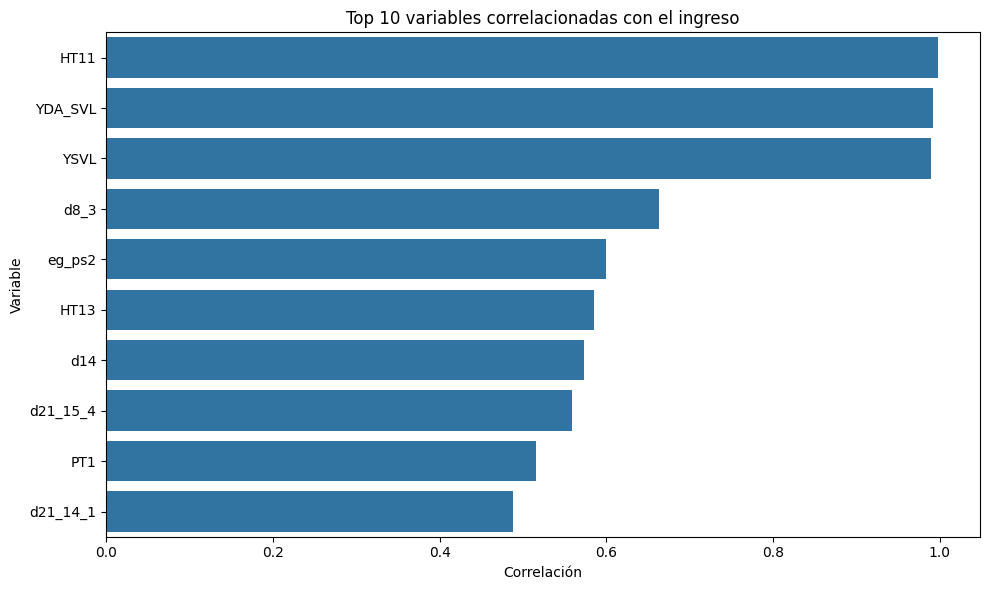

In [14]:
# === 7. Correlación con la variable objetivo (opcional visualización) ===
correlaciones = ech_encoded.corr()[target].drop(target).sort_values(ascending=False)
print("\nTop 10 variables correlacionadas con el ingreso (YDA):")
display(correlaciones.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=correlaciones.head(10).values, y=correlaciones.head(10).index)
plt.title("Top 10 variables correlacionadas con el ingreso")
plt.xlabel("Correlación")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

Verificando el diccionario, las variables correlacionadas con el ingreso son:
- HT11: INGRESO TOTAL DEL HOGAR CON VALOR LOCATIVO SIN SERVICIO DOMÉSTICO
- YDA_SVL: INGRESO DISPONIBLE AJUSTADO (SIN VALOR LOCATIVO)
- YSVL: INGRESO TOTAL DEL HOGAR SIN VALOR LOCATIVO SIN SERVICIO DOMÉSTICO
- d8_3: TENENCIA DE LA VIVIENDA > Monto del alquiler (efectivamente pagado o estimado)
- eg_ps2: MONTO MÍNIMO MENSUAL REQUERIDO PARA SATISFACER LAS NECESIDADES BÁSICAS
- HT13: VALOR LOCATIVO
- d14: CANTIDAD DE BAÑOS
- d21_15_4: ELEMENTOS DE CONFORT > Cantidad de microcomputadores que no son del Plan Ceibal
- PT1: TOTAL DE INGRESOS PERSONALES
- d21_14_1: ELEMENTOS DE CONFORT > Cantidad de equipos de aire acondicionado

In [ ]:
# === 8. Dataset listo para modelar ===
X = ech_encoded.drop(columns=[target])
y = ech_encoded[target]

print(f"\nDataset final listo para modelar:")
print("X:", X.shape)
print("y:", y.shape)